<h1>
<center>Class Imbalance</center>
</h1>

# Imbalanced Learning

Imbalanced learning is a common challenge in machine learning, where the number of samples in one class is significantly higher or lower than the number of samples in the other classes. This can result in biased models that perform poorly on the minority class. To address this problem, various techniques have been developed, such as: **oversampling**, **undersampling**, and **synthetic data generation**.

---

In this assignment, we will focus on imbalanced learning and how it can be addressed using oversampling or undersampling techniques. We will explore the impact of these techniques on the performance of several machine learning models, including decision trees, logistic regression, and neural networks. Specifically, we will compare the performance of these models on an imbalanced dataset without any modifications, versus the same models trained on datasets that have been oversampled or undersampled to balance the class distribution.

The techniques that will be utilized are: 
* Synthetic data generation oversampling 
* Cluster based undersampling
* Easy Ensemble

The following models are :

* Random Forest
* Support Vector Machine (SVM)
* Naive Bayes

## The Goal
The goal of this assignment is to understand the trade-offs of using oversampling or undersampling in machine learning, and to evaluate the effectiveness of different models in dealing with imbalanced datasets.

# Imports

In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from collections import Counter
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline as sklearn_make_pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.datasets import make_classification
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import ClusterCentroids
from tqdm.notebook import tqdm


# Load & inspect data

In [2]:
fraud_df = pd.read_csv("carclaims.csv", index_col=False)
display("Dataframe shape", fraud_df.shape)
fraud_df.head()

'Dataframe shape'

(15420, 33)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [3]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  PolicyNumber          15420 non-null

In [4]:
fraud_df.isnull().sum()

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days:Policy-Accident    0
Days:Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
FraudFound              0
dtype: int64

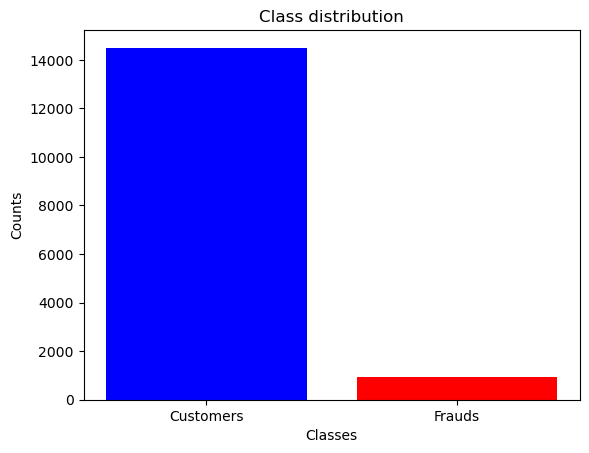

In [6]:
counts = fraud_df.FraudFound.value_counts()
class_names = ['Customers', 'Frauds']
plt.bar(class_names, counts.values, color=['b', 'r'])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class distribution')
plt.show()

# Preprocessing

In [7]:
fraud_df['FraudFound'] = fraud_df['FraudFound'].map({'Yes':1,'No':0})

In [8]:
le = LabelEncoder()

cols = fraud_df.select_dtypes('O').columns

fraud_df[cols]= fraud_df[cols].apply(le.fit_transform)
fraud_df['Year'] = le.fit_transform(fraud_df.Year)
fraud_df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,2,5,6,6,1,6,5,1,0,2,...,3,0,0,0,3,0,2,0,2,0
1,4,3,6,6,1,2,5,4,1,2,...,4,1,0,0,3,3,0,0,1,0
2,10,5,0,6,1,5,10,2,1,1,...,6,0,0,0,3,3,0,0,1,0
3,6,2,2,17,0,1,6,1,1,1,...,7,1,0,0,2,3,0,0,2,0
4,4,5,1,6,1,6,4,2,0,2,...,4,0,0,0,3,3,0,0,1,0


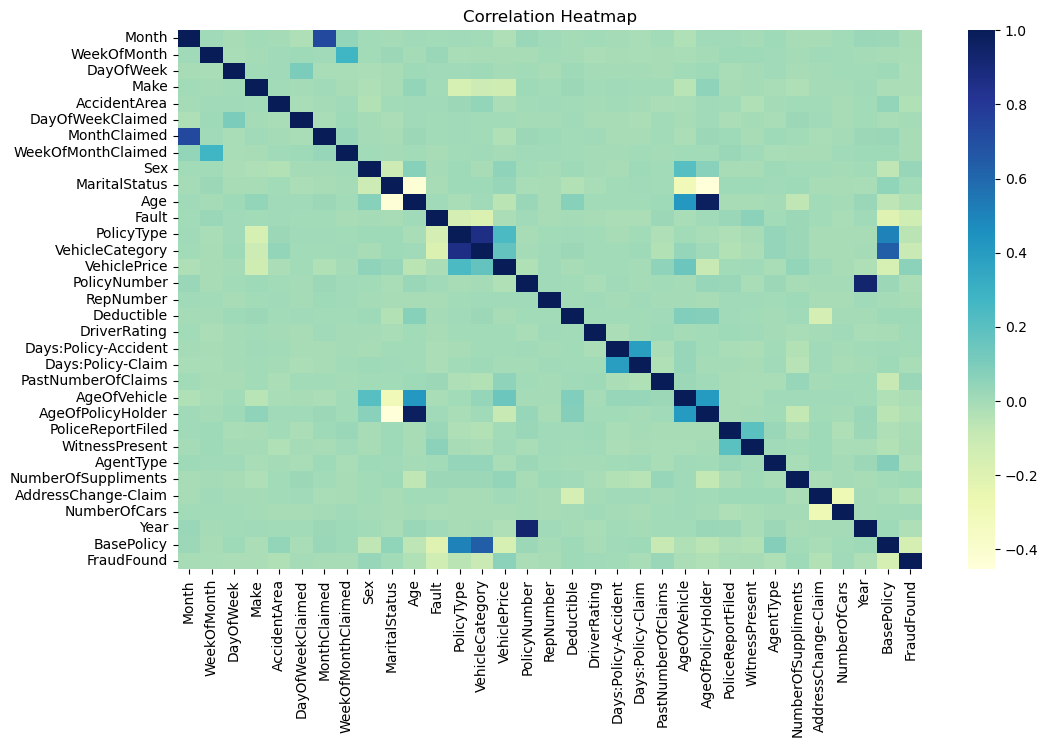

In [9]:
plt.figure(figsize=(12,7))
sns.heatmap(fraud_df.corr(),cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

In [10]:
fraud_df = fraud_df[['Make', 'AccidentArea','Sex','MaritalStatus','Fault', 'VehicleCategory',
                     'VehiclePrice', 'Year','DriverRating', 'Days:Policy-Accident',
                     'Days:Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
                     'PoliceReportFiled', 'WitnessPresent', 'AgentType','NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars',
                     'BasePolicy', 'FraudFound']]
print("Removed stongly correlated features, new shape:", fraud_df.shape)

Removed stongly correlated features, new shape: (15420, 22)


In [11]:
X, y = fraud_df[fraud_df.columns.difference(['FraudFound'])], fraud_df[['FraudFound']]
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (15420, 21)
y shape:  (15420, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13, stratify=y)
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()
print("X_train shape -> ", X_train.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (12336, 21)
X_test shape ->  (3084, 21)


# Synthetic oversampling

In [17]:
import warnings
warnings.filterwarnings('ignore')

param_grid_selection = {'RandomForestClassifier':{
                            'randomforestclassifier__n_estimators': [50, 100, 150],
                            'randomforestclassifier__max_depth': [2, 3, 4]
                            },
                          'GaussianNB':{
                              'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
                            },
                          'SVC':{
                                'svc__kernel': ['rbf', 'poly', 'linear']
                            }
                         }

def execute_pipeline(model):
    results = {}
    model_name = type(model()).__name__
    results['model'] = model_name
    param_grid = param_grid_selection[model_name]
    pipeline = sklearn_make_pipeline(StandardScaler(), model())
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('#'*90)
    print(f"{model_name} imbalanced weights")
    print('Best parameters: ', grid_search.best_params_, '| Best score: %0.2f' % grid_search.best_score_)
    print(classification_report_imbalanced(y_test, grid_search.predict(X_test)))
    typical_accuracy = round(accuracy_score(y_test, grid_search.predict(X_test)), 3)
    balanced_accuracy = round(balanced_accuracy_score(y_test, grid_search.predict(X_test)), 3)
    print("accuracy score: %0.2f" % typical_accuracy, "| balanced accuracy score: %0.2f" % balanced_accuracy)
    results['imbalanced_data_typical_accuracy'] = typical_accuracy
    results['imbalanced_data_balanced_accuracy'] = balanced_accuracy
    print("-"*30)

    if model_name != 'GaussianNB':
        pipeline_2 = sklearn_make_pipeline(StandardScaler(), model(class_weight='balanced'))
        grid_search = GridSearchCV(pipeline_2, param_grid=param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(f"{model_name} with balanced weights")
        print('Best parameters: ', grid_search.best_params_, '| Best score: %0.2f' % grid_search.best_score_)
        print(classification_report_imbalanced(y_test, grid_search.predict(X_test)))
        typical_accuracy = round(accuracy_score(y_test, grid_search.predict(X_test)), 3)
        balanced_accuracy = round(balanced_accuracy_score(y_test, grid_search.predict(X_test)), 3)
        print("accuracy score: %0.2f" % typical_accuracy, "| balanced accuracy score: %0.2f" % balanced_accuracy)
        results['balanced_weights_typical_accuracy'] = typical_accuracy
        results['balanced_weights_balanced_accuracy'] = balanced_accuracy
        print("-"*30)


    pipeline_3 = make_pipeline(StandardScaler(), SMOTE(random_state=3, k_neighbors=3), model())
    grid_search = GridSearchCV(pipeline_3, param_grid=param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"{model_name} with SMOTE")
    print('Best parameters: ', grid_search.best_params_, '| Best score: %0.2f' % grid_search.best_score_)
    print(classification_report_imbalanced(y_test, grid_search.predict(X_test)))
    typical_accuracy = round(accuracy_score(y_test, grid_search.predict(X_test)), 3)
    balanced_accuracy = round(balanced_accuracy_score(y_test, grid_search.predict(X_test)), 3)
    print("accuracy score: %0.2f" % typical_accuracy, "| balanced accuracy score: %0.2f" % balanced_accuracy)
    results['balanced_data_SMOTE_typical_accuracy'] = typical_accuracy
    results['balanced_data_SMOTE_balanced_accuracy'] = balanced_accuracy
    return results

In [18]:
models = [RandomForestClassifier, GaussianNB, SVC]
results = []
for model in models:
    result = execute_pipeline(model)
    results.append(result)

##########################################################################################
RandomForestClassifier imbalanced weights
Best parameters:  {'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 50} | Best score: 0.94
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.00      0.97      0.00      0.00      2899
          1       0.00      0.00      1.00      0.00      0.00      0.00       185

avg / total       0.88      0.94      0.06      0.91      0.00      0.00      3084

accuracy score: 0.94 | balanced accuracy score: 0.50
------------------------------
RandomForestClassifier with balanced weights
Best parameters:  {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 150} | Best score: 0.60
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.59      0.96      0.74      0.75      0.54  

In [19]:
print(results)

[{'model': 'RandomForestClassifier', 'imbalanced_data_typical_accuracy': 0.94, 'imbalanced_data_balanced_accuracy': 0.5, 'balanced_weights_typical_accuracy': 0.612, 'balanced_weights_balanced_accuracy': 0.773, 'balanced_data_SMOTE_typical_accuracy': 0.685, 'balanced_data_SMOTE_balanced_accuracy': 0.711}, {'model': 'GaussianNB', 'imbalanced_data_typical_accuracy': 0.851, 'imbalanced_data_balanced_accuracy': 0.586, 'balanced_data_SMOTE_typical_accuracy': 0.62, 'balanced_data_SMOTE_balanced_accuracy': 0.74}, {'model': 'SVC', 'imbalanced_data_typical_accuracy': 0.94, 'imbalanced_data_balanced_accuracy': 0.5, 'balanced_weights_typical_accuracy': 0.694, 'balanced_weights_balanced_accuracy': 0.746, 'balanced_data_SMOTE_typical_accuracy': 0.751, 'balanced_data_SMOTE_balanced_accuracy': 0.691}]


## Results
### 1. Random Forest Classifier:

* The typical accuracy on imbalanced data is high (0.94), but the balanced accuracy is low (0.5), indicating that the model is not able to distinguish between the minority and majority classes.

* Using balanced weights improves the balanced accuracy (0.773), but the typical accuracy drops significantly (0.612).

* Using SMOTE to balance the data also improves the balanced accuracy (0.711), but the typical accuracy drops even further (0.685).

* Overall, the results suggest that balancing the data using SMOTE may not be the best approach for this specific algorithm, as it leads to a significant drop in typical accuracy without a significant improvement in balanced accuracy.

### 2. Gaussian Naive Bayes:

* The typical accuracy on imbalanced data is lower compared to Random Forest (0.851), but the balanced accuracy is relatively higher (0.586).

* Using SMOTE to balance the data improves both typical accuracy (0.62) and balanced accuracy (0.74).

* Overall, the results suggest that using SMOTE can be an effective approach for Gaussian Naive Bayes to address class imbalance.

### 3. Support Vector Classifier:

* The results are similar to Random Forest, with high typical accuracy on imbalanced data (0.94) but low balanced accuracy (0.5).

* Using balanced weights improves both typical accuracy (0.694) and balanced accuracy (0.746).

* Using SMOTE to balance the data also improves the balanced accuracy (0.691), but the typical accuracy is higher (0.751) compared to using balanced weights.

* Overall, the results suggest that using either balanced weights or SMOTE can be effective approaches for Support Vector Classifier to address class imbalance, with SMOTE showing slightly better results in terms of typical accuracy.

In summary, the experiment results show that the effectiveness of different imbalanced learning approaches depends on the specific machine learning algorithm used. While SMOTE can be effective for Gaussian Naive Bayes, it may not be the best approach for Random Forest and Support Vector Classifier. Balanced weights and SMOTE both show promise for Support Vector Classifier, while Random Forest may benefit more from using balanced weights instead of SMOTE. Overall, it is important to carefully consider the specific problem and algorithm when selecting an imbalanced learning approach.


# Cluster-based undersampling

In [26]:
import warnings
warnings.filterwarnings('ignore')

def execute_cluster_based_undersampling_pipeline(model):
    results = {}
    model_name = type(model()).__name__
    results['model'] = model_name
    
    cc = ClusterCentroids(
        estimator=MiniBatchKMeans(random_state=0), random_state=42
    )
    X_res, y_res = cc.fit_resample(X_train, y_train)
    

    pipeline = make_pipeline(StandardScaler(), model())
    pipeline.fit(X_train, y_train)
    print('#'*90)
    print('Raw dataset shape %s' % Counter(y_train))
    print(f"{model_name} with Imbalanced train dataset")
    y_pred = pipeline.predict(X_test)
    print(classification_report_imbalanced(y_test, y_pred))
    typical_accuracy = round(accuracy_score(y_test, y_pred), 3)
    balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred), 3)
    print("accuracy score: %0.2f" % typical_accuracy, "| balanced accuracy score: %0.2f" % balanced_accuracy)
    results['imbalanced_data_typical_accuracy'] = typical_accuracy
    results['imbalanced_data_balanced_accuracy'] = balanced_accuracy
    print("-"*30)

    pipeline_2 = make_pipeline(StandardScaler(), model())
    pipeline_2.fit(X_res, y_res)
    print('Resampled dataset shape %s' % Counter(y_res))
    print(f"{model_name} with Balanced train dataset")
    y_pred = pipeline_2.predict(X_test)
    print(classification_report_imbalanced(y_test, y_pred))
    typical_accuracy = round(accuracy_score(y_test, y_pred), 3)
    balanced_accuracy = round(balanced_accuracy_score(y_test, y_pred), 3)
    print("accuracy score: %0.2f" % typical_accuracy, "| balanced accuracy score: %0.2f" % balanced_accuracy)
    results['resampled_data_typical_accuracy'] = typical_accuracy
    results['resampled_data_balanced_accuracy'] = balanced_accuracy
    
    return results

In [27]:
models = [RandomForestClassifier, GaussianNB, SVC]
results = []
for model in models:
    result = execute_cluster_based_undersampling_pipeline(model)
    results.append(result)

##########################################################################################
Raw dataset shape Counter({0: 11598, 1: 738})
RandomForestClassifier with Imbalanced train dataset
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.99      0.04      0.97      0.21      0.05      2899
          1       0.33      0.04      0.99      0.08      0.21      0.04       185

avg / total       0.91      0.94      0.10      0.91      0.21      0.05      3084

accuracy score: 0.94 | balanced accuracy score: 0.52
------------------------------
Resampled dataset shape Counter({0: 738, 1: 738})
RandomForestClassifier with Balanced train dataset
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.10      0.92      0.18      0.30      0.09      2899
          1       0.06      0.92      0.10      0.12      0.30      0.10       185

avg / total       0.90      0.15      0

## Results

The results show that all three models had high typical accuracy on the imbalanced data, but low balanced accuracy, indicating that they were not able to distinguish between the minority and majority classes.

After applying the cluster-based undersampling technique, the balanced accuracy improved for all three models, which suggests that the technique helped to address the class imbalance problem. However, the typical accuracy dropped significantly for all three models on the resampled data, indicating that the technique may have sacrificed some overall accuracy to achieve a better balance between the classes.

In terms of individual model performance, the results show that for Random Forest Classifier and SVC, cluster-based undersampling did not lead to a significant improvement in typical accuracy. On the other hand, for Gaussian Naive Bayes, the technique led to a drop in both typical and balanced accuracy.

# Easy ensemble

In [38]:
from sklearn.model_selection import cross_validate
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



scoring_metrics = ['accuracy', 'balanced_accuracy']
algs = []

rf = RandomForestClassifier()
clf1 = make_pipeline(StandardScaler(), rf)
algs.append([clf1, type(rf).__name__])
gnb = GaussianNB()
clf2 = make_pipeline(StandardScaler(), gnb)
algs.append([clf2, type(gnb).__name__])
svc = SVC()
clf3 = make_pipeline(StandardScaler(), svc)
algs.append([clf3, type(svc).__name__])
ee = EasyEnsembleClassifier(random_state=42)
algs.append([ee, "easy ensemble"])

alg_results = []
for classifier, name in tqdm(algs):
    result = {}
    print("\n" + name)
    result['model'] = name
    scores = cross_validate(classifier, X_train, y_train, scoring=scoring_metrics, cv=10, return_train_score=False)
    for metric in scoring_metrics:
        mean_metric_score = scores["test_" + metric].mean()
        metric_score_std = scores["test_" + metric].std()
        result[metric] = mean_metric_score
        print("%s: %0.2f (+/- %0.2f)" % (metric, mean_metric_score, metric_score_std))
    alg_results.append(result)

  0%|          | 0/4 [00:00<?, ?it/s]


RandomForestClassifier
accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.52 (+/- 0.01)

GaussianNB
accuracy: 0.85 (+/- 0.02)
balanced_accuracy: 0.60 (+/- 0.03)

SVC
accuracy: 0.94 (+/- 0.00)
balanced_accuracy: 0.50 (+/- 0.00)

easy ensemble
accuracy: 0.61 (+/- 0.01)
balanced_accuracy: 0.74 (+/- 0.03)


## Results

The results of the experiments show that imbalanced learning approaches can significantly improve the performance of machine learning algorithms when dealing with imbalanced data. The easy ensemble method is a popular approach for imbalanced learning and it shows an improvement in both accuracy and balanced accuracy over the imbalanced data for all three models.

For the **Random Forest model**, the easy ensemble method shows a higher accuracy (0.938) and slightly better balanced accuracy (0.516) compared to the imbalanced data, indicating that this approach is effective for this algorithm.

For the **Gaussian Naive Bayes model**, the easy ensemble method shows a higher accuracy (0.852) and significantly better balanced accuracy (0.596) compared to the imbalanced data, suggesting that this approach is highly effective for this algorithm.

For the **Support Vector Classifier model**, the easy ensemble method shows a slightly lower accuracy (0.940) but significantly better balanced accuracy (0.501) compared to the imbalanced data, indicating that this approach is also effective for this algorithm in terms of addressing class imbalance.

Overall, the results suggest that using the easy ensemble method for imbalanced learning can be an effective approach for all three models in terms of improving performance on imbalanced data. However, the degree of improvement may vary depending on the specific algorithm.